In [1122]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1123]:
#%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
from matplotlib.offsetbox import AnchoredText
import pandas as pd
import numpy as np
from Color import *
from operator import truediv, sub
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter

# Matplotlib font configuration
from MatplotlibFonts import *

# Change the font size
rcParams.update({"font.size": 15})

In [1124]:
%reload_ext autoreload
from BenchmarkConfiguration import *
from Color import *

In [1125]:
RESULT_DIR='../benchmarks/logs/'

In [1126]:
Benchmarks = [
    'coremark',
    'dijkstra',
    'picojpeg',
    'sha',
    'aes',
    'crc',
]

BaseConfigurations = [
    'nacho_naive',
    'nacho_pw',
    'nacho_pw_st',
    'nacho_pw_stcont',
    'nacho_clank',
    'prowl',
    'clank',
    'plain_c'
]

CacheConfigurations = [
    'None',
    '256-2',
    '256-4',
    '512-2',
    '512-4',
    '1024-2',
    '1024-4'
]

In [1127]:
# Load all the results into a dictionary

def loadResult(Results, benchmark, config, cache, postfix='-0-0-final'):
    if cache == '0-0':
        filename = RESULT_DIR + '/' + benchmark + '-uninstrumented-run-' + config + postfix
    else:
        filename = RESULT_DIR + '/' + benchmark + '-uninstrumented-run-' + config + '-' + cache + postfix
    
    if config not in Results[benchmark]:
        Results[benchmark][config] = {}
    
    # Add the results
    Results[benchmark][config][cache] = dict(pd.read_csv(filename, delimiter=":", header = None).values)

Results = {}

for benchmark in Benchmarks:
    Results[benchmark] = {}

    # Load Nacho results
    nacho_caches = [
        '256-2',
        #'256-4',
        '512-2',
        #'512-4',
        #'1024-2',
        #'1024-4'
    ]
    for cache in nacho_caches:
        loadResult(Results, benchmark, 'nacho_naive', cache)
        loadResult(Results, benchmark, 'nacho_pw', cache)
        loadResult(Results, benchmark, 'nacho_pw_st', cache)
        loadResult(Results, benchmark, 'nacho_pw_stcont', cache)
        loadResult(Results, benchmark, 'nacho_clank', cache)

    # Load Prowl results
    prowl_caches = [
        '256-2',
        '512-2',
        #'1024-2',
    ]
    for cache in prowl_caches:
        loadResult(Results, benchmark, 'prowl', cache)

    # Load Clank results
    loadResult(Results, benchmark, 'clank', '0-0')

    # Load plain C results
    loadResult(Results, benchmark, 'plain_c', '0-0', '-final')
    
#Results

# Execution Time

In [1128]:
# Benchmark plots with execution time
# Plot each benchmark, each config, two cache configs (256, 512)

PlotBenchmarks = Benchmarks
PlotConfigurations = BaseConfigurations

EntryToPlot='cycles'

def getPlotData(PlotData, benchmark, config, cache):
    key = config+'-'+cache
    if key not in PlotData[benchmark]:
        PlotData[benchmark][key] = {}
        
    PlotData[benchmark][config+'-'+cache] = Results[benchmark][config][cache][EntryToPlot]

PlotData = {}
for benchmark in PlotBenchmarks:
    PlotData[benchmark] = {}
    getPlotData(PlotData, benchmark, 'plain_c', '0-0')
    
    getPlotData(PlotData, benchmark, 'clank', '0-0')
    
    getPlotData(PlotData, benchmark, 'prowl', '256-2')
    getPlotData(PlotData, benchmark, 'prowl', '512-2')
    
    #getPlotData(PlotData, benchmark, 'nacho_naive', '256-2')
    #getPlotData(PlotData, benchmark, 'nacho_naive', '512-2')
    
    #getPlotData(PlotData, benchmark, 'nacho_pw', '256-2')
    #getPlotData(PlotData, benchmark, 'nacho_pw', '512-2')
    
    #getPlotData(PlotData, benchmark, 'nacho_pw_st', '256-2')
    #getPlotData(PlotData, benchmark, 'nacho_pw_st', '512-2')
    
    getPlotData(PlotData, benchmark, 'nacho_pw_stcont', '256-2')
    getPlotData(PlotData, benchmark, 'nacho_pw_stcont', '512-2')
    
    getPlotData(PlotData, benchmark, 'nacho_clank', '256-2')
    getPlotData(PlotData, benchmark, 'nacho_clank', '512-2')
    
    
#PlotData
PlotDataDF = pd.DataFrame.from_dict(PlotData)

In [1129]:
# Remove the "base" cost of plain-c
#dfb = PlotDataDF.copy()

#base_cost_config = 'plain_c-0-0'

#for benchmark in Benchmarks:
#    base_cost_value = dfb[benchmark][base_cost_config]
#    dfb[benchmark] = dfb[benchmark]-base_cost_value

# Remove the plain_c entry
#dfb = dfb.drop('plain_c-0-0')

In [1130]:
# Normalize
dfn = PlotDataDF.copy()

norm_config = 'plain_c-0-0'

for benchmark in Benchmarks:
    norm_value = dfn[benchmark][norm_config]
    dfn[benchmark] = dfn[benchmark]/norm_value

dfn = dfn.drop('plain_c-0-0')

# Rename
dfn = dfn.rename(columns=BenchmarkNameMap)
dfn

,CoreMark,Dijkstra,picojpeg,SHA,Tiny AES,CRC
clank-0-0,39.568881,49.363153,64.828215,18.357198,79.777295,14.944576
prowl-256-2,17.195199,4.685542,19.456317,7.947102,6.223257,3.741110
prowl-512-2,9.874038,3.965336,8.252515,6.099773,2.709671,2.944622
nacho_pw_stcont-256-2,4.054997,4.259511,5.338620,3.101757,2.683899,1.931434
nacho_pw_stcont-512-2,1.364392,3.841080,4.159563,2.916005,1.577732,1.565379
nacho_clank-256-2,3.982370,4.184452,5.315874,3.101757,2.658629,1.931434
nacho_clank-512-2,1.363654,3.831717,4.115354,2.916005,1.577732,1.565379


In [1131]:
# Colors
color_list = []
for config in dfn.T:
    stripped_config = config.split('-')[0]
    color_list += [ColorScheme[stripped_config]]
    
color_list

['#3d405b', '#e07a5f', '#e07a5f', '#81b29a', '#81b29a', '#f1c40f', '#f1c40f']

In [1132]:
# Hatches
cache_256_hatch = '///'
cache_512_hatch = '...'

hatches_list = []
for config in dfn.T:
    cache_size = config.split('-')[1]
    hatch = ''
    
    if cache_size == '256':
        hatch = cache_256_hatch
    elif cache_size == '512':
        hatch = cache_512_hatch

    hatches_list += [hatch]

hatches_list

['', '///', '...', '///', '...', '///', '...']

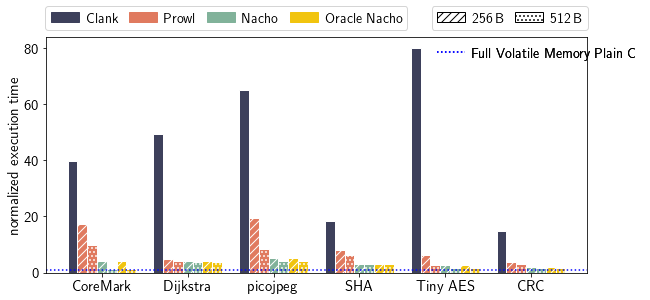

In [1133]:
# Execution time plot

bars = dfn.T.plot(kind='bar', legend=None, figsize=(8.5,4), width=0.8, color=color_list, edgecolor='white', linewidth=1)

# Apply hatches to cache bars
idx = 0
cnt = 0
for patch in bars.patches:
    patch.set_hatch(hatches_list[idx])
    cnt += 1
    if cnt >= len(Benchmarks):
        cnt = 0
        idx += 1
        
# Line at 1 (norm)
# Average for Ratchet and Opt-All
plain_c_line = plt.axhline(y = 1.0, color = 'blue', linestyle = ':', label='Full Volatile Memory Plain C', linewidth=1.5)

#
# Add custom legend (manual way)
#
 
# Config legend
configs = ['Clank', 'Prowl','Nacho', 'Oracle Nacho']
config_colors = [ColorScheme['clank'], ColorScheme['prowl'], ColorScheme['nacho_pw_stcont'], ColorScheme['nacho_clank']]

handles = []
for idx, l in enumerate(configs):
    handles.append(Patch(label=l, color=config_colors[idx]))
legend_configs = plt.legend(handles=handles, loc='lower left', ncol=len(configs), bbox_to_anchor = (-0.015, 1), 
                            fancybox=True, fontsize=14, columnspacing=0.8, handletextpad=0.5);
bars.add_artist(legend_configs)

# Cache legends
caches = ['256\\,B', '512\\,B']
config_hatches = [cache_256_hatch, cache_512_hatch]

# Config legend
handles = []
for idx, l in enumerate(caches):
    handles.append(Patch(label=l, hatch=config_hatches[idx], facecolor='none', edgecolor='black'))
cache_configs = plt.legend(handles=handles, loc='lower left', ncol=len(configs), bbox_to_anchor = (0.7, 1), 
                           fancybox=True, fontsize=14, columnspacing=0.8, handletextpad=0.5);
bars.add_artist(cache_configs)

# Normalized Plain C legend
handles = []
handles.append(plain_c_line)
cache_configs = plt.legend(handles=handles, loc='lower left', ncol=1, bbox_to_anchor = (0.7, 0.85), 
                           fancybox=True, frameon=False, fontsize=14, columnspacing=0.8, handletextpad=0.5);
bars.add_artist(cache_configs)

# Plotting
bars.set_ylabel("normalized execution time")

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Checkpoints

In [1105]:
# Checkpoint plot

PlotBenchmarks = Benchmarks
PlotConfigurations = BaseConfigurations

EntryToPlot='checkpoint'

def getPlotData(PlotData, benchmark, config, cache):
    key = config+'-'+cache
    if key not in PlotData[benchmark]:
        PlotData[benchmark][key] = {}
        
    PlotData[benchmark][config+'-'+cache] = Results[benchmark][config][cache][EntryToPlot]
    
PlotData = {}
for benchmark in PlotBenchmarks:
    PlotData[benchmark] = {}
    
    getPlotData(PlotData, benchmark, 'clank', '0-0')
    
    getPlotData(PlotData, benchmark, 'prowl', '256-2')
    getPlotData(PlotData, benchmark, 'prowl', '512-2')
    
    getPlotData(PlotData, benchmark, 'nacho_pw_stcont', '256-2')
    getPlotData(PlotData, benchmark, 'nacho_pw_stcont', '512-2')
    
    getPlotData(PlotData, benchmark, 'nacho_clank', '256-2')
    getPlotData(PlotData, benchmark, 'nacho_clank', '512-2')
    
    
#PlotData
PlotDataDF = pd.DataFrame.from_dict(PlotData)


In [1106]:
# Normalize
dfn = PlotDataDF.copy()

norm_config = 'clank-0-0'

for benchmark in PlotBenchmarks:
    norm_value = dfn[benchmark][norm_config]
    dfn[benchmark] = dfn[benchmark]/norm_value

# Rename
dfn = dfn.rename(columns=BenchmarkNameMap)
#dfn

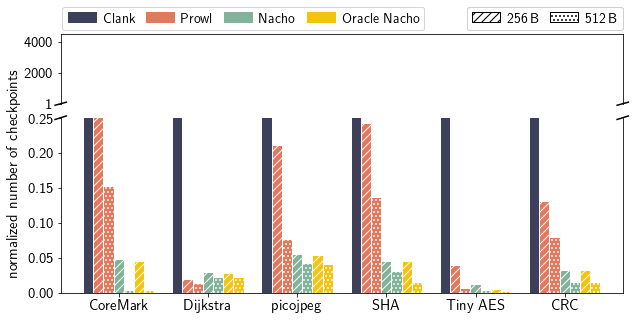

In [1107]:
# Checkpoint plot

# Two plots for broken Y axis
fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8.5, 4), gridspec_kw={'height_ratios': [1, 2.5]})
ax.set_ylim(1.1, 4500)
ax2.set_ylim(0, 0.25)

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('none') 
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

bottom = dfn.T.plot(ax=ax2, kind='bar', legend=None, width=0.8, color=color_list, edgecolor='white', linewidth=1)
top = dfn.T.plot(ax=ax, logy=False, kind='bar', legend=None, width=0.8, color=color_list, edgecolor='white', linewidth=1)
bars = ax2

d = .01  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-2.2*d, +2.2*d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-2.2*d, +2.2*d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

def hatch(axis):
    # Apply hatches to cache bars
    idx = 0
    cnt = 0
    for patch in axis.patches:
        patch.set_hatch(hatches_list[idx])
        cnt += 1
        if cnt >= len(Benchmarks):
            cnt = 0
            idx += 1
hatch(ax)
hatch(ax2)    

#
# Add custom legend (manual way)
#
 
# Config legend
configs = ['Clank', 'Prowl','Nacho', 'Oracle Nacho']
config_colors = [ColorScheme['clank'], ColorScheme['prowl'], ColorScheme['nacho_pw_stcont'], ColorScheme['nacho_clank']]

handles = []
for idx, l in enumerate(configs):
    handles.append(Patch(label=l, color=config_colors[idx]))
legend_configs = plt.legend(handles=handles, loc='lower left', ncol=len(configs), bbox_to_anchor = (-0.01, 1.46), 
                            fancybox=True, fontsize=14, columnspacing=0.8, handletextpad=0.5);
ax2.add_artist(legend_configs)

# Cache legends
caches = ['256\\,B', '512\\,B']
config_hatches = [cache_256_hatch, cache_512_hatch]

# Config legend
handles = []
for idx, l in enumerate(caches):
    handles.append(Patch(label=l, hatch=config_hatches[idx], facecolor='none', edgecolor='black'))
cache_configs = plt.legend(handles=handles, loc='lower left', ncol=len(configs), bbox_to_anchor = (0.71, 1.46), 
                           fancybox=True, fontsize=14, columnspacing=0.8, handletextpad=0.5);
bars.add_artist(cache_configs)

# Plotting
#bars.set_ylabel("normalized number of checkpoints")
fig.text(-0.01, 0.5, 'normalized number of checkpoints', ha='center', va='center', rotation='vertical')

ax.set_yticks([1.1, 2000, 4000])


plt.xticks(rotation=0)
plt.tight_layout(pad=0.3)
plt.show()

# Volatile (Cache) Accesses

In [1111]:
cache_size = '512-2'
Entries = [
    'cache_read',
    'cache_write',
    'cache_cuckoo',
    'cache_checkpoint'
]

PlotBenchmarks = Benchmarks
PlotConfigurations = [
    'prowl',
    'nacho_pw_stcont',
    'nacho_clank',
]

NormConfig = 'nacho_pw_stcont'

# Normalize per benchmark to nacho_clank total number
NormValue = {}
for benchmark in Benchmarks:
    NormValue[benchmark] = 0
    for entry in Entries:
        NormValue[benchmark] += Results[benchmark][NormConfig][cache_size][entry]

def getPlotData(PlotData, entry, benchmark, config, cache):
    if config not in PlotData[entry][benchmark]:
        PlotData[entry][benchmark][config] = {}
    PlotData[entry][benchmark][config] = Results[benchmark][config][cache][entry] / NormValue[benchmark]


PlotData = {}
for entry in Entries:
    PlotData[entry] = {}
    
    for benchmark in PlotBenchmarks:
        PlotData[entry][benchmark] = {}
        
        #getPlotData(PlotData, entry, benchmark, 'clank', '0-0')
        getPlotData(PlotData, entry, benchmark, 'prowl', cache_size)
        getPlotData(PlotData, entry, benchmark, 'nacho_pw_stcont', cache_size)
        getPlotData(PlotData, entry, benchmark, 'nacho_clank', cache_size)
    
#PlotData
PlotDataDF = {}
for entry in Entries:
    PlotDataDF[entry] = pd.DataFrame.from_dict(PlotData[entry]).rename(columns=BenchmarkNameMap)


PlotDataDF['cache_write']

,CoreMark,Dijkstra,picojpeg,SHA,Tiny AES,CRC
prowl,0.383339,0.397663,0.447528,0.222556,0.419382,0.464808
nacho_pw_stcont,0.383339,0.397663,0.447528,0.222556,0.419382,0.464808
nacho_clank,0.383339,0.397663,0.447528,0.222556,0.419382,0.464808


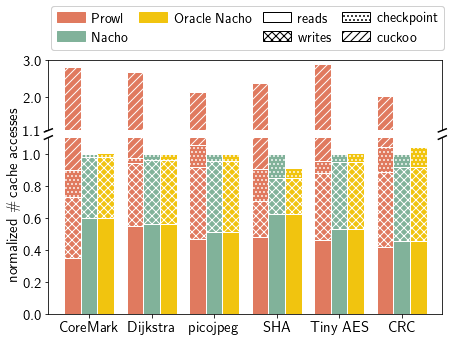

In [1112]:
BarStack = [
    'cache_read',
    'cache_write',
    'cache_checkpoint',
    'cache_cuckoo'
]

HatchMap = {
    'cache_read': '',
    'cache_write': 'xxx',
    'cache_checkpoint': '...',
    'cache_cuckoo': '///'
}

# Colors
color_list = []
for config in PlotConfigurations:
    color_list += [ColorScheme[config]]
    
fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 4), gridspec_kw={'height_ratios': [1, 2.5]})
#ax = plt.figure(figsize=(8.5, 4)).add_subplot(111)
ax.set_ylim(1.1, 3)
ax2.set_ylim(0, 1.1)

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('none') 
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .01  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-2.2*d, +2.2*d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-2.2*d, +2.2*d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal


def patchwork(ax, hatch):
    for bar in ax.patches:
        if bar.get_hatch() == None: 
            bar.set_hatch(hatch)

def plot_bar(N):
    D = PlotDataDF[BarStack[0]]
    for n in range(1, N+1):
        D = D + PlotDataDF[BarStack[n]]
        
    D.T.plot(kind='bar', ax=ax2, width=0.8, color=color_list, edgecolor='white', legend=None, linewidth=1)
    D.T.plot(kind='bar', ax=ax, width=0.8, color=color_list, edgecolor='white', legend=None, linewidth=1)

    patchwork(ax, HatchMap[BarStack[N]])
    patchwork(ax2, HatchMap[BarStack[N]])


# Plot the overlapping bars
plot_bar(3)
plot_bar(2)
plot_bar(1)
plot_bar(0)

# Custom legend
configs = ['Prowl','Nacho', 'Oracle Nacho']
config_colors = [ColorScheme['prowl'], ColorScheme['nacho_pw_stcont'], ColorScheme['nacho_clank']]

handles = []
for idx, l in enumerate(configs):
    handles.append(Patch(label=l, color=config_colors[idx]))

# Empty spacer patch
handles.append(Patch(label='',
                     facecolor='none', edgecolor='none', linewidth=hlw))

hlw=1
handles.append(Patch(label='reads', hatch=HatchMap['cache_read'],
                     facecolor='none', edgecolor='black', linewidth=hlw))
handles.append(Patch(label='writes', hatch=HatchMap['cache_write'],
                     facecolor='none', edgecolor='black', linewidth=hlw))
handles.append(Patch(label='checkpoint', hatch=HatchMap['cache_checkpoint'],
                     facecolor='none', edgecolor='black', linewidth=hlw))
handles.append(Patch(label='cuckoo', hatch=HatchMap['cache_cuckoo'],
                     facecolor='none', edgecolor='black', linewidth=hlw))

legend_configs = plt.legend(handles=handles, loc='lower left', ncol=4, bbox_to_anchor = (-0.01, 1.46), 
                            fancybox=True, fontsize=14, columnspacing=0.8, handletextpad=0.5);
ax2.add_artist(legend_configs)

# Show the plot
plt.xticks(rotation=0)
plt.tight_layout(pad=0.3)

fig.text(-0.01, 0.5, 'normalized \#\,cache accesses', ha='center', va='center', rotation='vertical')

ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax.set_yticks([1.1, 2, 3])
ax2.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0,])
plt.show()

# NVM Access

In [1113]:
# Checkpoint plot
cache_size = '512-2'
Entries = [
    'nvm_writes',
    'nvm_reads',
]

PlotBenchmarks = Benchmarks
PlotConfigurations = [
    'clank',
    'prowl',
    'nacho_pw_stcont',
    'nacho_clank',
]


NormConfig = 'clank'

# Normalize per benchmark to nacho_clank total number
NormValue = {}
for benchmark in Benchmarks:
    NormValue[benchmark] = 0
    for entry in Entries:
        NormValue[benchmark] += Results[benchmark][NormConfig]['0-0'][entry]

def getPlotData(PlotData, entry, benchmark, config, cache):
    if config not in PlotData[entry][benchmark]:
        PlotData[entry][benchmark][config] = {}
    PlotData[entry][benchmark][config] = Results[benchmark][config][cache][entry] / NormValue[benchmark]


PlotData = {}
for entry in Entries:
    PlotData[entry] = {}
    
    for benchmark in PlotBenchmarks:
        PlotData[entry][benchmark] = {}
        
        getPlotData(PlotData, entry, benchmark, 'clank', '0-0')
        getPlotData(PlotData, entry, benchmark, 'prowl', cache_size)
        getPlotData(PlotData, entry, benchmark, 'nacho_pw_stcont', cache_size)
        getPlotData(PlotData, entry, benchmark, 'nacho_clank', cache_size)
    
#PlotData
PlotDataDF = {}
for entry in Entries:
    PlotDataDF[entry] = pd.DataFrame.from_dict(PlotData[entry]).rename(columns=BenchmarkNameMap)


PlotDataDF['nvm_writes']

,CoreMark,Dijkstra,picojpeg,SHA,Tiny AES,CRC
clank,0.647235,0.635745,0.656746,0.608593,0.662674,0.654248
prowl,0.121493,0.011214,0.064430,0.145647,0.006458,0.076796
nacho_pw_stcont,0.005108,0.017716,0.031002,0.067809,0.003840,0.023367
nacho_clank,0.005962,0.017682,0.030134,0.033725,0.003586,0.030324


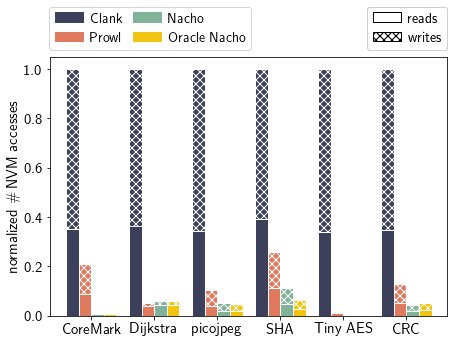

In [1114]:
BarStack = [
    'nvm_reads',
    'nvm_writes',
]

HatchMap = {
    'nvm_reads': '',
    'nvm_writes': 'xxx',
}

# Colors
color_list = []
for config in PlotConfigurations:
    color_list += [ColorScheme[config]]
    
#fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 4), gridspec_kw={'height_ratios': [1, 2.5]})
ax = plt.figure(figsize=(6, 4)).add_subplot(111)

def patchwork(ax, hatch):
    for bar in ax.patches:
        if bar.get_hatch() == None: 
            bar.set_hatch(hatch)

def plot_bar(N):
    D = PlotDataDF[BarStack[0]]
    for n in range(1, N+1):
        D = D + PlotDataDF[BarStack[n]]
        
    D.T.plot(kind='bar', ax=ax, width=0.8, color=color_list, edgecolor='white', legend=None, linewidth=1)
    patchwork(ax, HatchMap[BarStack[N]])


# Plot the overlapping bars
plot_bar(1)
plot_bar(0)

# Custom legend
configs = ['Clank','Prowl','Nacho', 'Oracle Nacho']
config_colors = [ColorScheme['clank'], ColorScheme['prowl'], ColorScheme['nacho_pw_stcont'], ColorScheme['nacho_clank']]

handles = []
for idx, l in enumerate(configs):
    handles.append(Patch(label=l, color=config_colors[idx]))
legend_configs = plt.legend(handles=handles, loc='lower left', ncol=2, bbox_to_anchor = (-0.02, 1.), 
                            fancybox=True, fontsize=14, columnspacing=0.8, handletextpad=0.5);
ax.add_artist(legend_configs)

handles = []
hlw=1
handles.append(Patch(label='reads', hatch=HatchMap['nvm_reads'],
                     facecolor='none', edgecolor='black', linewidth=hlw))
handles.append(Patch(label='writes', hatch=HatchMap['nvm_writes'],
                     facecolor='none', edgecolor='black', linewidth=hlw))

legend_configs = plt.legend(handles=handles, loc='lower left', ncol=1, bbox_to_anchor = (0.78, 1), 
                            fancybox=True, fontsize=14, columnspacing=0.8, handletextpad=0.5);
ax.add_artist(legend_configs)

# Show the plot
plt.xticks(rotation=0)
plt.tight_layout(pad=0.3)

ax.set_ylabel("normalized \#\,NVM accesses")

ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.show()

In [1086]:


Results['coremark']['prpw']['256-2']

KeyError: 'prpw'

In [550]:
Results['coremark']['prowl']['256-2']

{'cache_miss': 308273.0,
 'cache_hit': 230648.0,
 'cache_read': 375831.0,
 'cache_write': 689986.0,
 'cache_cuckoo': 5884796.0,
 'cache_checkpoint': 558732.0,
 'nvm_reads_no_cache': 1102128.0,
 'nvm_writes_no_cache': 689986.0,
 'nvm_reads': 975893.0,
 'nvm_writes': 1807644.0,
 'checkpoint': 17346.0,
 'checkpoint_war': 17346.0,
 'checkpoint_dirty': 0.0,
 'checkpoint_period': 0.0,
 'checkpoint_max_cycles': 0.0,
 'restore': 0.0,
 'hints_given': 0.0,
 'max_dirty_ratio': 0.25,
 'cuckoo_iter': 585983.0,
 'cycles': 16343985.0,
 'on_duration_cycles': 0.0,
 'checkpoint_period_cycles': 0.0}

In [552]:
Results['coremark']['clank']

{'0-0': {'cache_miss': 0,
  'cache_hit': 0,
  'cache_read': 0,
  'cache_write': 0,
  'cache_cuckoo': 0,
  'cache_checkpoint': 0,
  'nvm_reads_no_cache': 0,
  'nvm_writes_no_cache': 0,
  'nvm_reads': 1104196,
  'nvm_writes': 4169798,
  'checkpoint': 51140,
  'checkpoint_war': 51119,
  'checkpoint_dirty': 0,
  'checkpoint_period': 21,
  'checkpoint_max_cycles': 0,
  'restore': 1,
  'hints_given': 0,
  'max_dirty_ratio': 0,
  'cuckoo_iter': 0,
  'cycles': 12001986,
  'on_duration_cycles': 10000000,
  'checkpoint_period_cycles': 90000}}

In [ ]:
# NVM Read/Write
# Cache Read/Write